<hr>
<h1> Genetic Tool to Cell Type Bayesian Mapper (GT2CT Bayesian Mapper)</h1>
<p> Authors: Nikhil Karthik$^1$ and Chaitali Khan$^2$<br>
$(1)$ American Physical Society, (2) NHLBI, NIH </p>

<hr>

<p> This notebook implements all the steps necessary to extract the cell type fractions from the GFP/RFP data in the STPT image data. The notebook explains the algorithm as you execute the cells sequentially. However, the explanations are short in this notebook, and for a more detailed explanation of the procedure, read <a href="https://github.com/astronikil/GT2CT/blob/main/notes/note.pdf"> this pdf document</a> .  </p>

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import gc 
from zipfile import ZipFile
from pathlib import Path
import requests

sys.path.append('./')

In [3]:
from sklearn.neighbors import NearestNeighbors

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None 

In [3]:
import SimpleITK as sitk
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [8]:
base_dir = './'
work_dir = './challenge/WORKDIR/'
data_dir = './brain_data/'
neural_net_dir = './model_weights/'

for directory in [work_dir, data_dir]:
    try:
        os.mkdir(directory )
        print('Directory ' + directory  + ' created successfully')
    except FileExistsError:
        print('Directory ' + directory  + ' already exists')

allen_download_base = Path('./brain_data/')
abc_cache = AbcProjectCache.from_cache_dir( allen_download_base )

Directory ./challenge/WORKDIR/ already exists
Directory ./brain_data/ already exists


<h2>Part-I: Setup MERFISH reconstructed and CCF coordinate systems</h2>

<h3> Input annotation arrays</h3>
<p>Load annotation arrays for CCF and MERFISH annotation arrays. We will need this to orient ourselves in the image data, and to pick the required parcels from the images.</p>
<p> First, import class voxel for easier handling of voxellated images like annotation arrays, and CCF registered STPT images. <br> Important note: class voxel automatically standardizes the voxel arrays to have z-y-x ordering. </p>

In [8]:
from src.voxel import voxel

<p> Load MERFISH annotation data</p>

In [10]:
"""" MERFISH resampled annotation at 0.01X0.01X0.2 mu  voxel """

merfish_template_files =\
 [ abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',\
                               file_name='resampled_average_template'),
   abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',\
                               file_name='resampled_annotation'),
   abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',\
                               file_name='resampled_annotation_boundary') ]

merfish_average_template = voxel(merfish_template_files[0], ordering = 'zyx')
merfish_annotation = voxel(merfish_template_files[1], ordering = 'zyx')
merfish_annotation_boundary = voxel(merfish_template_files[2], ordering = 'zyx')

merfish_annotation_boundary.image_info()

 size: [1100, 1100, 76] voxels
 spacing: (0.009999999776482582, 0.009999999776482582, 0.20000000298023224) mm


In [10]:
"""" CCF annotation at 25x25x25 micron voxels """

stpt25_template_files =\
 [ abc_cache.get_data_path(directory='Allen-CCF-2020',\
                               file_name='average_template_25'),
   abc_cache.get_data_path(directory='Allen-CCF-2020',\
                               file_name='annotation_25'),
   abc_cache.get_data_path(directory='Allen-CCF-2020',\
                               file_name='annotation_boundary_25') ]

stpt_average_template = voxel(stpt25_template_files[0], ordering = 'xyz')
stpt_annotation = voxel(stpt25_template_files[1], ordering = 'xyz')
stpt_annotation_boundary = voxel(stpt25_template_files[2], ordering = 'xyz')

stpt_annotation_boundary.image_info()

 size: [456, 320, 528] voxels
 spacing: (0.02500000037252903, 0.02500000037252903, 0.02500000037252903) mm


In [11]:
del merfish_template_files, stpt25_template_files
gc.collect()

20

<hr>
<h3>Input MERFISH dataframe containing cell coordinates and subclasses, and make MERFISH data left-right symmetric </h3>
<p> The main input/seed dataframe is the <code>cell_metadata_with_parcellation_annotation</code> from Allen Brain Institute, which is pruned to coordinate and subclass information alone.<p> 

In [12]:
cell_everything  = abc_cache.get_metadata_dataframe(
        directory='MERFISH-C57BL6J-638850-CCF',
        file_name='cell_metadata_with_parcellation_annotation',
        dtype={"cell_label": str}
        )

cell_everything.set_index('cell_label', inplace=True)

<hr>
<h4> Symmetrization of MERFISH data along the CCF y-axis</h4>
<p> We will be classifying the STPT data directly in the CCF coordinates. For this, we will train a neural network, which will need as much data as possible. For this, we can make use of the reflection symmetry of the CCF coordinate in the xy-plane. The code below creates a new column <code>z_ccf_folded</code> that "folds" as the MERFISH cells into the right lobe of the brain.</p>

In [13]:
cell_everything['z_ccf_reflected'] = stpt_annotation.Lx * stpt_annotation.dx - cell_everything['z_ccf']
cell_everything['z_ccf_folded'] = cell_everything[['z_ccf', 'z_ccf_reflected']].max(axis=1)

<hr>
<h4>Choose brain structure that needs to be analyzed.</h4>

In [14]:
BRAIN_STRUC = 'VISp'
PARCELLATION_TYPE = 'structure'

<hr>
<p>The primary dataframe that we will work with is <code>df_cell_xy</code> that is pruned down to to minimal number of columns necessary, and confined to the VISp (or the "BRAIN_STRUC") region of the brain.  If you are not going to be training a new neural network, we suggest that you delete the dataframe <code>cell_everything</code> to make space in RAM.</p>

In [15]:
select = (cell_everything['parcellation_'+PARCELLATION_TYPE] == BRAIN_STRUC)
df_cell_xy= cell_everything[select][['z_ccf_folded', 'z_ccf', 'y_ccf', 'x_ccf',\
                                    'x_reconstructed', 'y_reconstructed', 'z_reconstructed',\
                                    'subclass', 'supertype', 'cluster']]

In [16]:
df_cell_xy.head(2)

z_ccf_folded     z_ccf     y_ccf     x_ccf  \
cell_label                                                        
1019171912101090014      8.504722  2.895278  0.901237  9.509721   
1019171910102620041      8.924495  8.924495  1.222132  9.473174   

                     x_reconstructed  y_reconstructed  z_reconstructed  \
cell_label                                                               
1019171912101090014         2.808672         2.664345              4.4   
1019171910102620041         8.706420         2.838497              4.6   

                             subclass            supertype  \
cell_label                                                   
1019171912101090014  044 OB Dopa-Gaba  0162 OB Dopa-Gaba_1   
1019171910102620041   036 HPF CR Glut   0135 HPF CR Glut_1   

                                 cluster  
cell_label                                
1019171912101090014  0589 OB Dopa-Gaba_1  
1019171910102620041   0497 HPF CR Glut_1

<hr>
<h3> Find which z-slices of 25-micron CCF which contain the required brain structure (VISp). Then, find optimal CCF z-slices from those. </h3>
<p> The STPT images registered to CCF are in 25x25x25 micron voxels, whereas the MERFISH cells are registered to 10x10x200 micron voxels. There are two ways one could take: (1) Transform points/cells in STPT to MERFISH reconstructed coordinates. Or, (2) work in CCF coordinates for both STPT and MERFISH, and learn the continuous probability distributions for MERFISH subclasses as a function of (x_ccf, y_ccf, z_ccf) via interpolations. In this notebook, we will use method (2). </p>

<p> It is preferable to find STPT CCF slices on which mean distance to the nearest MERFISH cells are small to minimize interpolation errors and modeling artifacts. In the few cells below, we find such optimal CCF z-slices, that we will work with in the analysis.</p>
<hr>
<p> First, load Allen Brain Institute's <code>parcellation_to_parcellation_term_membership_acronym</code>. From this, we find which parcellations are present in the brain stucture we are interested in (i.e., VISp). Store those parcels in the numpy integer array <code>parcels_in_struc</code> </p>
<br>

In [19]:
pivot_25 = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation_to_parcellation_term_membership_acronym')
pivot_25 = pivot_25.set_index('parcellation_index')
select = (pivot_25[PARCELLATION_TYPE] == BRAIN_STRUC)

parcels_in_struc = pivot_25.index[select].to_numpy(dtype=np.int32)

print('Parcels in '+ BRAIN_STRUC+': ',parcels_in_struc)

Parcels in VISp:  [ 29 295 583 711 768 811]


<hr>
<p>Find z slices that contain VISp. The list <code>zccf_values_in_struc</code> will contain the such z slices. <br> For VISp, z slices range from 307 to 414; corresponding to 7.675 to 10.35 mm CCF z-coordinate.</p>

In [20]:
zccf_values_in_struc =[]
parcel_values_in_struc = []
for z in range(stpt_annotation.Lz):
    parcel = stpt_annotation.data['array'][z,:,:].copy()
    parcel = parcel.flatten()
    
    select = np.where( parcel > 0 )
    p_index = np.unique( parcel[select] )
    
    struc = pivot_25.loc[p_index][PARCELLATION_TYPE].to_list()
    
    if BRAIN_STRUC in struc:
       zccf_values_in_struc.append(z)
        
print('z-slices of 25-micron CCF annotation array that have '+BRAIN_STRUC+' are:\n', zccf_values_in_struc)

z-slices of 25-micron CCF annotation array that have VISp are:
 [307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414]


<hr>
<p>
Each point $x$ on a fixed CCF-slice lies closest to another corresponding MERFISH cell. Let's call this distance $D^{\text{CCF-to-MERFISH}}(x)$. To find how close a CCF-slice within VISp (or another region) is to the MERFISH slices, we calculate $D^{\text{CCF-to-MERFISH}}(x)$ for various x on that VISp CCF z-slice and average this over x in that 2D CCF slice. The cell below does this through a call to a function <code>dist_from_ccf_to_nearest_merfish</code>.
</p>

In [21]:
from src.misc import dist_from_ccf_to_nearest_merfish

k_neighbors = 2
ref_list = df_cell_xy[['z_ccf_folded', 'y_ccf', 'x_ccf' ]].to_numpy()
nbrs = NearestNeighbors(n_neighbors=1 + k_neighbors, algorithm='ball_tree').fit(ref_list)
def nearest_merfish_to_a_ccfcoord(ccf_coord):
    distances, _ = nbrs.kneighbors(ccf_coord)
    return distances

dist = np.array([ dist_from_ccf_to_nearest_merfish(stpt_annotation,
                                parcels_in_struc,
                                 zindex,
                                 nearest_merfish_to_a_ccfcoord,
                                 side = 'right') for zindex in zccf_values_in_struc])

The cell below plots the average distance ($D^{\text{CCF-to-MERFISH}}$) on various CCF z-slices that have the VISp (or the structure chosen by you). The black curve is the mean and the two red curves are the one-standard deviations (1-STD).  We put a tolerance of <code>z_cutoff</code> to the amount of CCF-MERFISH mismatch we are happy to live with at 1-STD level. For our analysis, we chose <code>z_cutoff = 0.02</code>.

The cell below the plot, stores all these "ideal" CCF z-slices in the list <code>z_ideal</code>. In the rest of the code, we will iterate over this list to perform the analysis of STPT arrays.

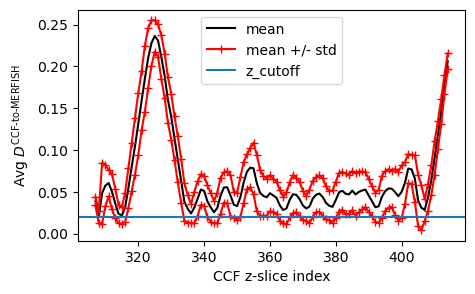

In [22]:
fig, ax = plt.subplots(1,1, figsize = (5, 3) )

""" Change cut-off below to make it more stringent/relaxed """
z_cutoff = 0.02

ax.plot(dist.T[0], dist.T[1], color='black', label = 'mean')
ax.plot(dist.T[0], dist.T[1]+dist.T[2], marker='+', color='r', label = 'mean +/- std')
ax.plot(dist.T[0], dist.T[1]-dist.T[2], marker='+', color='r')
ax.axhline(y=z_cutoff, label = 'z_cutoff')

ax.set_ylabel('Avg $D^{\\text{CCF-to-MERFISH}}$')
ax.set_xlabel('CCF z-slice index'); ax.set_xlabel('CCF z-slice index')
ax.legend()

plt.show()

In [23]:
select = (dist.T[1]-dist.T[2] < z_cutoff) & (dist.T[0] > 310)
z_ideal = dist[select].T[0].astype(np.int32)
    
print('\n Ideal CCF z-slices of STPT images in '+BRAIN_STRUC+\
      ' that are nearest to MERFISH cells are: \n\n', z_ideal)


 Ideal CCF z-slices of STPT images in VISp that are nearest to MERFISH cells are: 

 [313 314 315 316 334 335 336 337 341 342 343 344 349 350 351 363 364 365
 366 370 371 372 377 378 379 380 392 393 394 399 400 405 406 407]


<hr>
<h2>Part-II: Setup classifier to get spatial probability distributions of the subclasses</h2>

<p> VISp (or another brain structure you chose), has only a subset of the celltypes. In the Jupyter-cells below, we choose the celltypes/subclasses that are substantially present in VISp. After that, we either upload a pretrained neural network classifier for VISp, or freshly train one using MERFISH data to give the probability distributions for these chosen subclasses over the 3D CCF space in the neighborhood of VISp.</p>

<hr>
<h3> Choose subclasses of interest and prepare dictionaries </h3>
<p>
(We will keep talking about "subclass", but it could be class, cluster or supertype as well.)
    
Choose only celltype subclasses in VISp that have atleast <code> MIN_CELL = 10</code> number of cells. Then, prepare dictionaries to go from array indices to subclass name, and vice versa. This will come handy later on in the analysis.
</p>
<p>
1. <code>id_to_subclass</code> maps subclass to numpy indices.<br>
2. <code>subclass_to_id</code> maps numpy indices to subclass names.</br>
</p>
<h4>NOTE:</h4>
<p>set <code> PREDEFINED = False</code> only if using for new brain (sub)structures. For the challenge, leave it as <code>True</code>.</p>

In [24]:
PREDEFINED = True

if PREDEFINED:
    print('Using predefined subclass choices and ids')
    """
    Dictionary for converting string subclass names to array indices
    """

    id_to_subclass =            {
                0: "327 Oligo NN",
                1: "319 Astro-TE NN",
                2: "333 Endo NN",
                3: "334 Microglia NN",
                4: "029 L6b CTX Glut",
                5: "030 L6 CT CTX Glut",
                6: "028 L6b/CT ENT Glut",
                7: "052 Pvalb Gaba",
                8: "331 Peri NN",
                9: "326 OPC NN",
                10: "330 VLMC NN",
                11: "329 ABC NN",
                12: "002 IT EP-CLA Glut",
                13: "049 Lamp5 Gaba",
                14: "056 Sst Chodl Gaba",
                15: "046 Vip Gaba",
                16: "022 L5 ET CTX Glut",
                17: "006 L4/5 IT CTX Glut",
                18: "007 L2/3 IT CTX Glut",
                19: "004 L6 IT CTX Glut",
                20: "001 CLA-EPd-CTX Car3 Glut",
                21: "003 L5/6 IT TPE-ENT Glut",
                22: "005 L5 IT CTX Glut",
                23: "053 Sst Gaba",
                24: "332 SMC NN",
                25: "032 L5 NP CTX Glut",
                26: "047 Sncg Gaba",
                27: "051 Pvalb chandelier Gaba"
            }
else:
    print('Generating new subclass choices and ids. Did you mean to do this?')
    counts = df_cell_xy.groupby('subclass')['subclass'].count().to_dict()
    id_to_subclass = {}
    i_include = 0
    for subclass, cellcount in counts.items():
        if cellcount > 10:
            id_to_subclass[subclass] = i_include
            i_include+=1
    del counts, i_include
"""
Dictionary for converting array indices to subclass names, using the convention set in the above cell.
"""

subclass_to_id = {}
for key, value in id_to_subclass.items():
    subclass_to_id[value] = key

subclass_selected = list(subclass_to_id.keys())

NSUBCLASS = len(id_to_subclass.keys())
print('# of subclasses =', NSUBCLASS)

Using predefined subclass choices and ids
# of subclasses = 28


<h3> Upload/train neural network whose outputs are learnt Bayesian probabilities to find a subclass at a spatial location</h3>
<p>The purpose of the classifier is the following. Let $S$ be the set of such subclasses chosen above, and let $N$ be the total number of subclasses in the set (i.e., $N=|S|$). Given the data for 3D spatial locations of MERFISH cells, we want to learn a probability distribution function $P(s|x)$  that gives the probability to find a cell of subclass $s\in S$ at a point $x$, with $\sum_{s\in S} P(s|x) = 1$ for different $x$. </p>

<p> We find $P(s|x)$ for $x$ in CCF space for $x$ in VISp's 3D volume and VISp's immediate neighborhood.  We model $P(s|x)$ using neural network with a multilayer perceptron (MLP) architechture with weights $w$, $$ P(s|x) = \text{MLP}_w(x),$$ whose inputs are the 3 CCF coordinate components of $x$ (appropriate normalized discussed later), and outputs are the "logits", $\log\left(P(s|x)\right)$ for all $s\in S$.</p>

<hr>
<p>Create MLP neural network, and upload pretrained weights (available for VISp) or train. The model is loaded into <code>prob_model</code>. </p>

<p> For VISp, we have used an MLP with 5 layers with <code>ReLU</code> activations. The maximum number of hidden units is 64, which was sufficient for VISp. The user is free to tweak/replace <code>FeedForward</code> as long as input size is 3 and output size is the number of subclasses.</p>

In [25]:
from src.probability_models import FeedForward

nfeat_in = 3
nhidden = 64
nlayers = 5
nfeat_out = NSUBCLASS

prob_model = FeedForward(nfeat_in = 3,
                         nfeat_out = NSUBCLASS,
                         nhidden = 64,
                         nlayers = 5
                        )

<p>Since we are interested in actual Bayesian probabilities and not in just the top-pick for the celltype at $x$, it is important to train the MLP classifier with cross-entropy (CE) loss.</p>

In [26]:
loss_fn = nn.CrossEntropyLoss()

<p>The input to the MLP is a scaled function of CCF coordinate $x$ so that it is easier to train. For this, we take the brain structure (VISp), and find its centroid $(x_\text{centroid}, y_\text{centroid}, z_\text{centroid})$. Let $\sigma_{xy}$ be the root mean square distance of VISp cells from the z-axis passing through the centroid. Let $\sigma_z$ be the standard deviation of the $z$-coordinate displacement of VISp cells from the centroid. Then, we define the scaled coordinates of cells in VISp as 
$$ \tilde{x} = \frac{x - x_\text{centroid}}{\sigma_{xy}}; \tilde{y} = \frac{y - y_\text{centroid}}{\sigma_{xy}}; \tilde{z} = \frac{z - z_\text{centroid}}{\sigma_{z}}.$$ <p></p>

<p> The cell below finds the centroids, and define the scaling function <code>scale_pos</code> whose output must be passed to <code>prob_model</code></p>

In [27]:
x_centroid, y_centroid, z_centroid = df_cell_xy[['z_ccf_folded', 'y_ccf', 'x_ccf']].mean()

sigma_xy = np.sqrt(((df_cell_xy['z_ccf_folded'] - x_centroid)**2 + (df_cell_xy['y_ccf'] - y_centroid)**2).mean())
sigma_z = (df_cell_xy['x_ccf'] - z_centroid).std()

def scale_pos(ccf_pos,
              center = np.array([x_centroid, y_centroid, z_centroid]), 
              scale  = np.array([sigma_xy, sigma_xy, sigma_z])
             ):
    return ((ccf_pos -center)/scale).astype(np.float32)

print(sigma_xy, sigma_z)

0.6073482862694355 0.5450505002898821


<p>Load pretrained weights for the model (available for VISp) or want to train a model yourself? Use <code>USE_PRETRAINED = True</code> if use pretrained model in VISp. </p>

In [28]:
USE_PRETRAINED = True

if USE_PRETRAINED:
    try:
        mmddyy_id = '' #Set this to '_MMDDYYHHMM' id if you are using a version saved by you in ./model_weights
        wfile = './model_weights/'+BRAIN_STRUC+'/MLP_weights_' +str(nfeat_in)+'_'+str(nfeat_out)+'_'+str(nhidden)+'_'+str(nlayers)+mmddyy_id+'.pt'
        prob_model.load_state_dict(torch.load(wfile, weights_only=True))
        print('Successfully loaded '+wfile)
    except:
        print('Weights not present for specified model. Reset "USE_PRETRAINED = False", and execute cell again. Model needs to be trained from scratch!')
        USE_PRETRAINED = None #Just a dummy so that cells that follow will throw error.

Successfully loaded ./model_weights/VISp/MLP_weights_3_28_64_5.pt


<hr>
<p> ***<br> <b>If you are planning to train a neural network from scratch using MERFISH data, read this and execute the cells below. Else, move on directly to Part-III.</b></br> ***<br> In the cells below, we setup training and testing data sets. After that we run the 15 epochs of test+train using the MLP defined above using cross-entropy loss.</p>
<hr>
<p> We now define what is VISp and its "neighborhood".  We could train the MLP using only the MERFISH cells within VISp. For VISp, there are about 61000 cells.  To train better, we need more data -- and they should be near VISp so that functional form learnt in non-VISp region has some constraining effect in VISp region. We do this by including all MERFISH cells within VISp and also cells with their scaled coordinates $\tilde{x}^2 + \tilde{y}^2 < 1.5 \sigma_{xy}^2$. For VISp this increases data size to 211052.</p>

In [31]:
if not USE_PRETRAINED:
    select = (cell_everything['parcellation_'+PARCELLATION_TYPE] == BRAIN_STRUC) | (np.sqrt( (cell_everything['z_ccf_folded'] - x_centroid)**2 +\
         (cell_everything['y_ccf'] - y_centroid)**2) <  1.5 * sigma_xy)

    cell_training_set = cell_everything[select][['z_ccf_folded', 'z_ccf', 'y_ccf', 'x_ccf',\
                                    'x_reconstructed', 'y_reconstructed', 'z_reconstructed',\
                                    'subclass', 'supertype', 'cluster']]
    select = cell_training_set['subclass'].isin(subclass_selected)
    cell_training_set = cell_training_set[select]
    print('extended training data size: ', len(cell_training_set))
else:
    print('nothing to do here')

nothing to do here


<hr>
<p> We create a pytorch Dataset object <code>merfishdata</code> to feed batches of data into the neural network training and testing. The test and train split is 90% and 10% of the full data. <code>merfishdata</code> returns the scaled coordinates of a MERFISH cell and the index of the actual subclass of the MERFISH cell. </p>

In [32]:
if not USE_PRETRAINED:
    class merfishdata(Dataset):
        def __init__(self, df):
            super().__init__()
            self.df = df
        
        def __len__(self):
            return len(self.df)
    
        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            
            coord = self.df.iloc[idx][['z_ccf_folded', 'y_ccf', 'x_ccf']].to_numpy().astype(np.float32)
            scaled_coord = torch.from_numpy( scale_pos(coord) )
            subclass = subclass_to_id[ self.df.iloc[idx]['subclass'] ]
            return {'coord': scaled_coord, 'subclass': subclass}

    full_dataset = merfishdata(df = cell_training_set)

    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
else:
    print('nothing to do here')

nothing to do here


<hr>
<p> Perform <code>epochs = 20</code> training and testing cycles. Using larger <code>batch_size = 128</code> seems to perform better in this dataset. The model did not show signs of overfitting even if run through many epochs, and simply plateaued. In the code below, we pick the version of MLP weights that resulted in the lowest cross-entropy loss in the 20 epochs. This part might need the user to tweak the parameters, choice of <code>optimizer</code> and notice the progress in training for usage in non-VISp areas where we did not test.</p>
<p>This simple analysis code is meant to be used in CPU, and takes about 20 mins to cycle through epochs in VISp. Have |patience if there is more data in the brain area you are using!</p>

In [36]:
if not USE_PRETRAINED:
    from src.training import train_loop, test_loop

    batch_size = 128
    epochs = 20
    learning_rate = 0.004

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

    optimizer = torch.optim.AdamW(prob_model.parameters(), lr=learning_rate)

    loss_min = 1000.0
    for t in range(epochs):
        train_loop(train_dataloader, prob_model, loss_fn, optimizer)
        loss = test_loop(test_dataloader, prob_model, loss_fn)
    
        if loss <= loss_min:
            params = prob_model.state_dict()
            loss_min = loss
        
        prob_model.load_state_dict(params)
else:
    print('nothing to do here')

nothing to do here


<hr>
<p>Store the weights after training.</p>

In [35]:
if not USE_PRETRAINED:
    from src.utils import generate_mmddyyhrmin_string

    try:
        os.mkdir(neural_net_dir + BRAIN_STRUC)
        print("Directory created successfully")
    except FileExistsError:
        print("Directory already exists")

    torch.save(prob_model.state_dict(), neural_net_dir + BRAIN_STRUC + 
           '/MLP_weights_' +str(nfeat_in)+'_'+str(nfeat_out)+'_'+str(nhidden)+'_'+str(nlayers)+\
           '_' + generate_mmddyyhrmin_string() + '.pt')

else:
    print('nothing to do here')

nothing to do here


<hr>
<h2> Part-III: Input STPT image file in CCF, choose channel, and extract thresholded image for voxel sampling</h2>

<p>The code below is written to download data from Allen Brain Map My Section challenge. For other purposes, the user should place the zip file containing the data in <code>./work_dir</code> and change the value of <code>zipfile</code>. </p>

In [29]:
mms_df = pd.read_csv('./challenge/Training Set-Table 1.csv')
mms_df.columns

Index(['MapMySectionsID', 'Genetics Tools Type', 'STPT Data File Path',
       'STPT Thumbnail Image', 'Neuroglancer File Path',
       'CCF Registered Image File Path', 'Target_Cell_Population',
       'Qualitative Image Assessment', '|', 'ABC.NN', 'Astro.TE.NN',
       'CLA.EPd.CTX.Car3.Glut', 'Endo.NN', 'L2.3.IT.CTX.Glut',
       'L4.5.IT.CTX.Glut', 'L5.ET.CTX.Glut', 'L5.IT.CTX.Glut',
       'L5.NP.CTX.Glut', 'L6.CT.CTX.Glut', 'L6.IT.CTX.Glut', 'L6b.CTX.Glut',
       'Lamp5.Gaba', 'Lamp5.Lhx6.Gaba', 'Lymphoid.NN', 'Microglia.NN',
       'OPC.NN', 'Oligo.NN', 'Peri.NN', 'Pvalb.Gaba', 'Pvalb.chandelier.Gaba',
       'SMC.NN', 'Sncg.Gaba', 'Sst.Chodl.Gaba', 'Sst.Gaba', 'VLMC.NN',
       'Vip.Gaba'],
      dtype='object')

<hr>
<p>Choose the test set: <code>MMS.training.abc</code> where <code>abc</code> is the zero padded three integer version of (isamp_index + 1). The rows of that test set details from Allen Brain .csv file is shown as the output. </p>

In [30]:
isamp_index = 57
mms_df.loc[isamp_index]

MapMySectionsID                                                    MMS.training.058
Genetics Tools Type                                                    Enhancer AAV
STPT Data File Path               s3://allen-genetic-tools/tissuecyte/1288840843...
STPT Thumbnail Image              https://s3.us-west-2.amazonaws.com/allen-genet...
Neuroglancer File Path            https://neuroglancer-demo.appspot.com/#!s3://a...
CCF Registered Image File Path    https://s3.us-west-2.amazonaws.com/map-my-sect...
Target_Cell_Population                                                        L5_ET
Qualitative Image Assessment      strong, dense, L5_Glutamatergic; weak, dense, ...
|                                                                                 |
ABC.NN                                                                          0.0
Astro.TE.NN                                                                     0.0
CLA.EPd.CTX.Car3.Glut                                                       

<hr>
<p>The cell below will download the datafile in zip format if it is not already present in <code>./work_dir</code>. </p>

In [31]:
zipfile = work_dir+'train_'+str(isamp_index)+'.zip'

if not(os.path.exists(zipfile)):
    url = mms_df.iloc[isamp_index]['CCF Registered Image File Path']
    print('Downloading from: '+url )
    response = requests.get(url)
    if response.status_code == 200:
        with open(zipfile, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully')
    else:
        print('Failed to download file')
else:
    print('File already downloaded.')
    
with ZipFile(zipfile, 'r') as zObject:
    zObject.extract(
            "resampled_green_25.nii.gz", path=work_dir)
    zObject.extract(
            "resampled_red_25.nii.gz", path=work_dir)
zObject.close()

File downloaded successfully


<hr>
<p> Import function <code>plot_section</code> which is a helper routine for plotting images </p>

In [38]:
from src.plotunits import plot_section

<h3> Choose color channel</h3>
<p> The cell below displays the red and green channels of the STPT image of the CCF slice <code>zindex</code>. <br><br><b>***We have not automated the choice of channel, and leave it to the user's choice based on the low-res greyscale images or use the related high-res OME Zarr high resolution image *** </b></p>

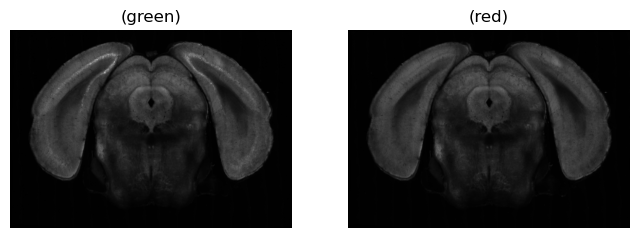

In [34]:
red_channel = voxel(work_dir + 'resampled_red_25.nii.gz', ordering='xyz')
green_channel = voxel(work_dir + 'resampled_green_25.nii.gz', ordering='xyz')

zindex = 380
fig, ax = plt.subplots(1, 2,  figsize=(8, 16))

_, ax[0] = plot_section( green_channel.data['array'][zindex, :, :], ax = ax[0], cmap = plt.cm.Greys_r, vmin=0, vmax=2000)

_, ax[1] = plot_section( red_channel.data['array'][zindex, :, :], ax = ax[1], cmap = plt.cm.Greys_r, vmin=0, vmax=2000)

ax[0].set_title('(green)')
ax[1].set_title('(red)')
plt.show()

<p><b> Enter channel to use:</b></p>

In [36]:
CHANNEL = green_channel #red_channel or green_channel. Set one here based on your judgment.

<p>The cell below sets the values of some hyperparameters. with <code>WHICH_SIDE</code>, you can choose to analyze the STPT image only on the left side of brain, or the right side, or both sides. We set <code>WHICH_SIDE = 'both'</code>.   The <code>SHOW_ALL_PLOTS = True</code> will show all plots that are output during analysis. Can be set to False, if you do not want to see those details.</p>

In [37]:
WHICH_SIDE = 'both'   #to be picked from 'right', 'left' or 'both'
SHOW_ALL_PLOTS = True

assert WHICH_SIDE in ['right', 'left', 'both'], "to be picked from 'right', 'left' or 'both'"

if WHICH_SIDE == 'right':
    side_list = ['right']
elif WHICH_SIDE == 'left':
    side_list = ['left']
else:
    side_list = ['left', 'right']

<h3> Applying threshold to CCF registered image to extract relevant voxels</h3>

<p>We work directly with the 25 micron resolution CCF registered STPT images to extract the likely spatial distribution of GFP positive cells. The notebook cells that follow walk you through the strategy for picking threshold to remove "unwanted" diffuse background and possibly GFP positive cells that one is not confident whether to count them in or not.</p>

<hr>
<h3> Demonstration of thresholding via an example CCF slice</h3>

<p>
Functionality to crop just a brain structure is useful, so explain a bit in detail here. We can crop/zoom into the smallest square z-section enclosing VISp (or your input BRAIN_STRUC) through a call to function <code>crop_structure</code>. It takes the voxel object that needs to be cropped on <code>zindex</code> slice over a structure containing the list of parcels <code>parcels_in_struc</code>. The annotation array corresponding to the voxel object is also passed via <code>annotation_voxobj</code>.  The function returns two dictionaries <code>im</code> and <code>im_range</code> both with keys <code>'left'</code> and <code>'right'</code>. <code>im['left']</code> contains the cropped square numpy matrix on left half of brain, and similarly on the right in <code>im['right']</code>.   <code>im_range['left']</code> contains the actual row and column coordinates at the four corners of the square, which will help place the array back on full brain slice after performing transformation on the cropped image.
</p>

In [39]:
from src.utils import crop_structure

zindex = 380

im, im_range = crop_structure(vox = CHANNEL, 
                              zindex=zindex, 
                              parcels_in_struc=parcels_in_struc, 
                              annotation_voxobj=stpt_annotation)

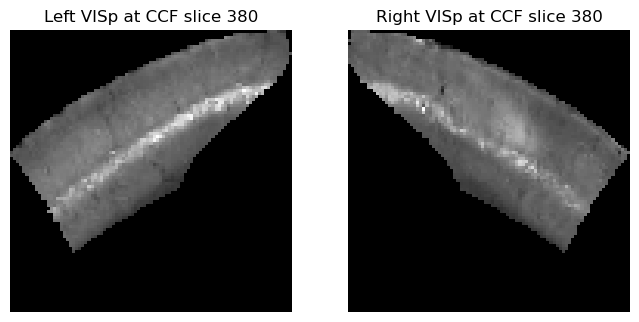

In [40]:
fig, ax = plt.subplots(1, 2,  figsize=(8, 5))
_, ax[0] = plot_section( im['left'], ax = ax[0], cmap = plt.cm.Greys_r)
_, ax[1] = plot_section( im['right'], ax = ax[1], cmap = plt.cm.Greys_r)

plt.title('CCF z-slice = ' + str(zindex))
ax[0].set_title('Left '+BRAIN_STRUC+' at CCF slice ' + str(zindex))
ax[1].set_title('Right '+BRAIN_STRUC+' at CCF slice ' + str(zindex))
plt.show()

<hr>
<p>We obtain the value of lower threshold intensity on a given slice through the variable <code>F_CUTOFF = 0.90 </code> to select only the top 10% of the bright voxels in that CCF z-slice. </cp>

In the cell below, we obtain the threshold intensities on the left and right VISp areas on the same zslice.

In [41]:
F_CUTOFF = 0.98

def threshold(A):
     select = (A > 1)
     B = A[select].copy()
     thresh = np.percentile(B, F_CUTOFF * 100)
     return thresh
    
threshl, threshr = threshold(im['left']), threshold(im['right'])

<hr>
<p> We plot the probability density function for the intensities of voxel in the selected z-slice below. We also show the thresholds as the dashed vertical lines.

Typically, one finds the intensity probability density function to be two-peaked or three-peaked, with actual image probably hidden in the tail of the second peak. One could see this by adjusting the neuroglancer intensity selection sliders. The choice of <code>F_CUTOFF = 0.98</code> is motivated by this observation. The user is free to set <code>F_CUTOFF</code> if something else seems better.
</p>

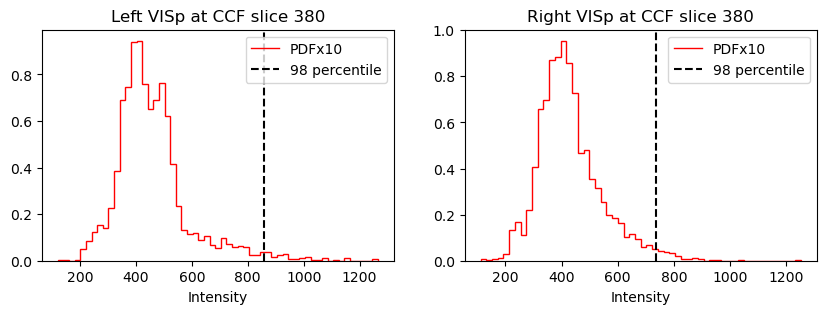

In [42]:
"""  plot the data. """
def cumulative_histogram_and_threshold(A, f, nsteps = 25):
    if not 0 <= f <= 1:
        raise ValueError("Fraction 'f' must be between 0 and 1.")
    select = (A > 1)
    B = A[select].copy()
    B_max, B_min = np.max(B), np.min(B)
    bins =int((B_max - B_min)/nsteps)
    counts, bin_edges = np.histogram(B, bins=bins, density=True)
    cumulative_counts = np.cumsum(counts)
    cumulative_distribution = np.insert(cumulative_counts, 0, 0)
    return counts*nsteps, cumulative_counts*nsteps, bin_edges

def plot_image_histogram(ax, img, thresh, nsteps = 20, title = ''):
    count, cumulcount, bins = cumulative_histogram_and_threshold(img, F_CUTOFF, nsteps=nsteps)
    ax.stairs(count*10, bins, label='PDFx10', color = 'red')
    #ax.stairs(cumulcount, bins, label='CDF', color = 'blue')
    ax.axvline(x=thresh, label=str(int(F_CUTOFF*100))+ ' percentile', color = 'black', ls='--')
    ax.set_xlabel('Intensity')
    ax.set_title(title)
    ax.legend()
    
fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_image_histogram(ax[0], im['left'], threshl, nsteps = 20, title = 'Left '+BRAIN_STRUC+' at CCF slice ' + str(zindex))
plot_image_histogram(ax[1], im['right'], threshr, nsteps = 20, title = 'Right '+BRAIN_STRUC+' at CCF slice ' + str(zindex))
plt.show()

<hr>
<p>
In the cell below, we plot the images of VISp after placing the lower threshold. The resulting images should show few bright voxels, and get rid of the background. Doesn't look good? Try going back and changing <code>F_CUTOFF</code>. Once, settled on <code>F_CUTOFF</code>, move to the next cells.
</p>

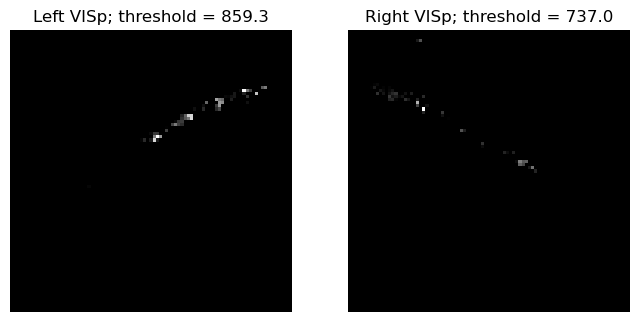

In [43]:
fig, ax = plt.subplots(1, 2,  figsize=(8, 5))
_, ax[0] = plot_section( im['left'], ax = ax[0], cmap = plt.cm.Greys_r, vmin = threshl)
_, ax[1] = plot_section( im['right'], ax = ax[1], cmap = plt.cm.Greys_r, vmin = threshr)

plt.title('CCF z-slice = ' + str(zindex))
ax[0].set_title('Left ' + BRAIN_STRUC + f'; threshold = {threshl:5.1f}')
ax[1].set_title('Right '+ BRAIN_STRUC + f'; threshold = {threshr:5.1f}')
plt.show()

<h3> Get cropped VISp areas in all all CCF slices and their respective slicewise thresholds </h3>
<p>
The cell below applies the above procedure that we did for one slice for all the slices in <code>z_ideal</code>, and stores the needed information in <code>collect_stpt_data</code>, which is a list of dictionaries.
</p>

In [44]:
max_dim = 0
max_intensity = 0
collect_stpt_data = []

for islice, zindex in enumerate(z_ideal): 
    
    im, im_range = crop_structure(vox = CHANNEL, 
                                  zindex=zindex, 
                                  parcels_in_struc=parcels_in_struc, 
                                  annotation_voxobj=stpt_annotation)

    for side in ['left', 'right']:
        
        thresh = threshold(im[side])

        max_intensity = max(max_intensity, np.max(im[side]))

        collect_stpt_data.append({'z': zindex, 
                          'image': im[side],
                          'side' : side,
                          'range': im_range[side], 
                          'thresh': thresh})

        max_dim = max(max_dim, im[side].shape[0])

num_images = len(collect_stpt_data)

<h3> Choose a global threshold that is uniformly applied to all CCF slices of VISp</h3>
<p>
    In the few above cells, we chose "local" thresholds to left and right VISp areas in each CCF slice. While we may apply this local threshold, we decided to use a common "global" threshold that we will apply to all VISp areas in all slices uniformly. This, we hoped, will reduce any bias/fine tuning, and will prevent picking voxels from a slice that would be considered a background noice in another brighter slice; in contrast, for the "local" thresholding, we /will/ pick some voxels from all slices by construction.
</p>

<p> For the "global" threshold, we use the median value of all the "local" thresholds obtained above. We allow for brain-side-dependence (seen in few training data set) in GFP/RFP cell brightness by allowing this global threshold to be side dependent. </p> 

<p>The plot below shows the "local" threshold from left and right VISp areas as a function of CCF z-slice index. The median "global" threshold from left and right sides are also shown.</p>

In [45]:
lst = {}
lst['left'] = []
lst['right'] = []
GLOBAL_INTENSITY_THRESH = {}
for dat in collect_stpt_data:
    lst[dat['side']].append(dat['thresh'])
    
GLOBAL_INTENSITY_THRESH['left'] = np.median(lst['left'])
GLOBAL_INTENSITY_THRESH['right'] = np.median(lst['right'])
print(GLOBAL_INTENSITY_THRESH)

{'left': 875.5, 'right': 801.7300000000002}


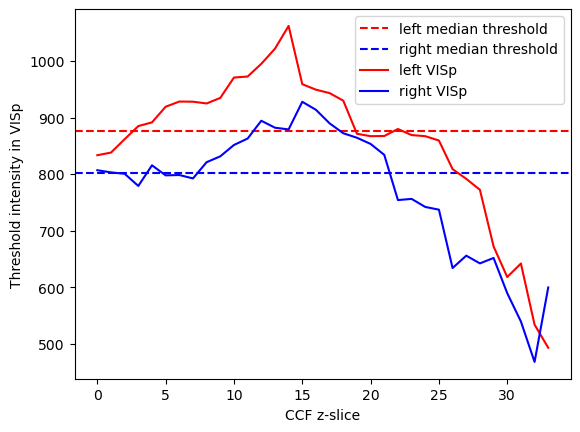

In [46]:
plt.axhline(y = GLOBAL_INTENSITY_THRESH['left'], label = 'left median threshold', color = 'red', ls = '--')
plt.axhline(y = GLOBAL_INTENSITY_THRESH['right'], label = 'right median threshold', color = 'blue', ls = '--')
plt.plot(lst['left'], color = 'red', label = 'left ' + BRAIN_STRUC) 
plt.plot(lst['right'], color = 'blue', label = 'right ' + BRAIN_STRUC) 
plt.xlabel('CCF z-slice')
plt.ylabel('Threshold intensity in ' + BRAIN_STRUC)
plt.legend()
plt.show()

<p>
Sample some CCF z-slices, and show the intensity histograms, VISp images without thresholding, after applying slice-specific "local" threshold, and after applying the globally fixed median threshold.  
</p>

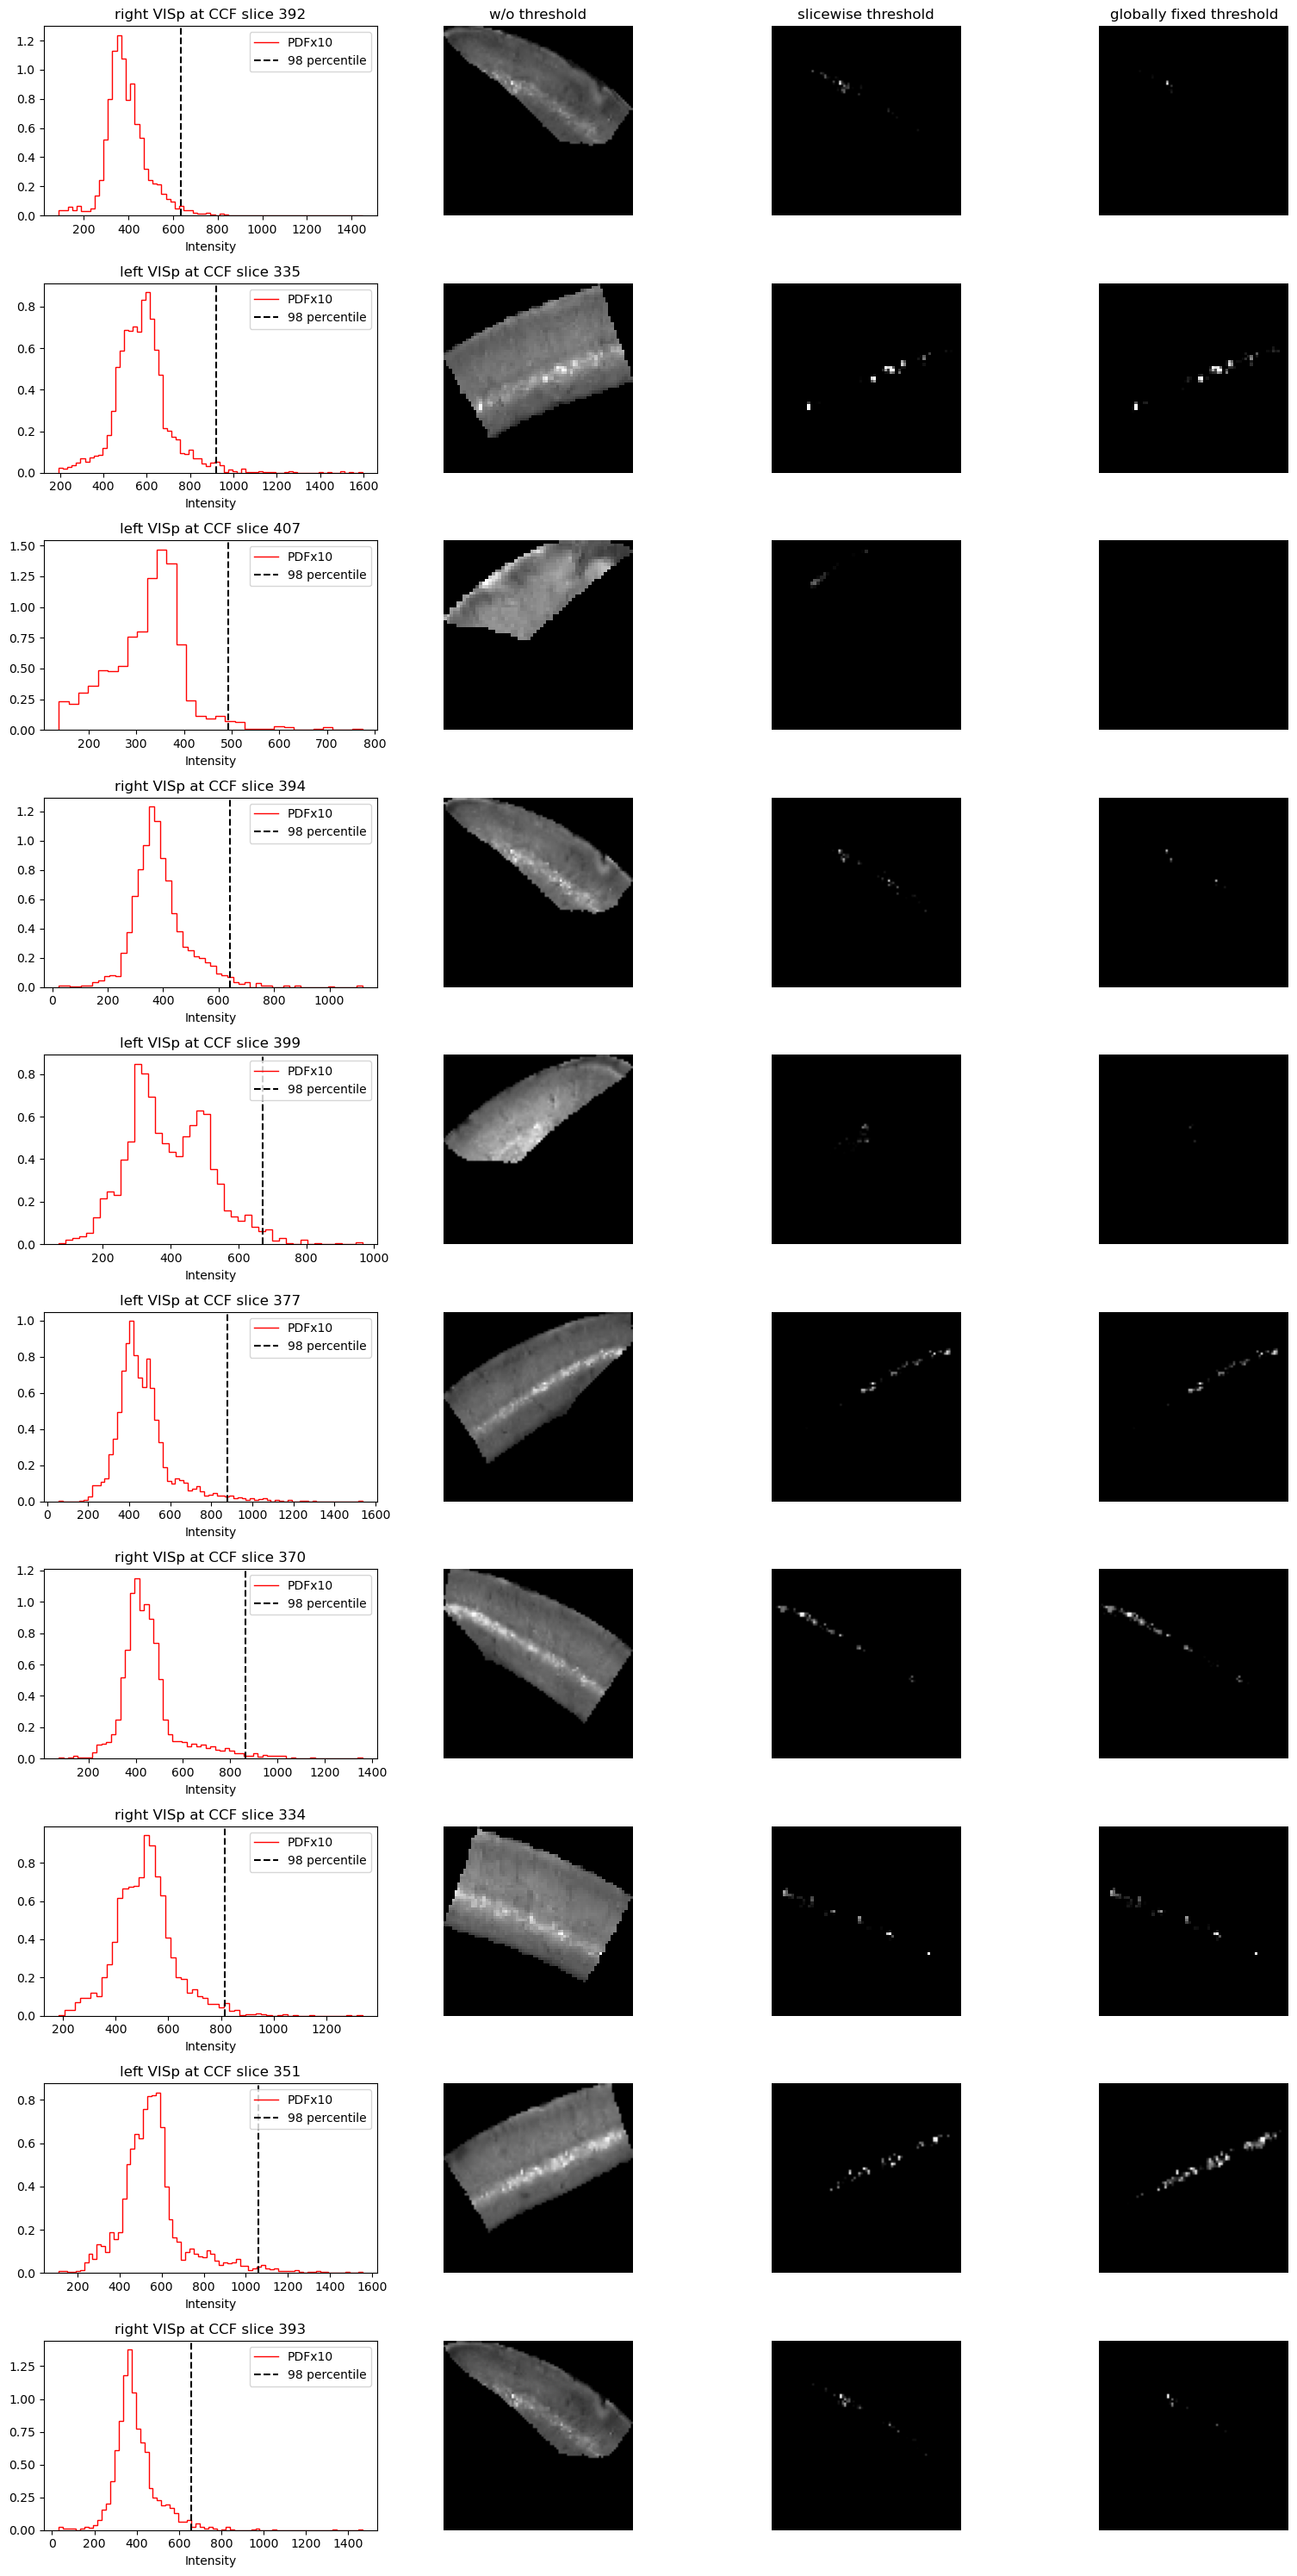

In [47]:
import random

SHOW_ALL_PLOTS = True
if SHOW_ALL_PLOTS:
    fig, ax = plt.subplots(10, 4,  figsize=(4*4, 3 * 10) )
    
    random_stpt_slices = random.sample(collect_stpt_data, 10)

    for j, ccf_zslice in enumerate(random_stpt_slices): 

        im = ccf_zslice['image']
        side = ccf_zslice['side']

        plot_image_histogram(ax[j][0], ccf_zslice['image'], ccf_zslice['thresh'], 
                         nsteps = 20, title = ccf_zslice['side']+' '+BRAIN_STRUC+' at CCF slice ' + str(ccf_zslice['z']))
        plot_section(ccf_zslice['image'], ax = ax[j][1], cmap = plt.cm.Greys_r, vmax = GLOBAL_INTENSITY_THRESH[side] + 500)
        plot_section(ccf_zslice['image'], ax = ax[j][2], cmap = plt.cm.Greys_r, vmin=ccf_zslice['thresh'], vmax = GLOBAL_INTENSITY_THRESH[side] + 500)
        plot_section(ccf_zslice['image'], ax = ax[j][3], cmap = plt.cm.Greys_r, vmin=GLOBAL_INTENSITY_THRESH[side], vmax = GLOBAL_INTENSITY_THRESH[side] + 500)

    ax[0][1].set_title('w/o threshold')
    ax[0][2].set_title('slicewise threshold')
    ax[0][3].set_title('globally fixed threshold')
    plt.tight_layout()
    plt.show()

<h3> Monte Carlo sampling of points from the STPT images weighted by their intensities</h3>

<p>CCF STPT images are at a 25 micron low-resolution, and it is difficult to pin point a voxel and say with confidence whether a GFP (RFP) cell is there or not. The above thresholding gets rid of the noise and "obvious" voxels that we more or less know to to be "not GFP cells". Of those voxels that survived thresholding we cannot be 100% sure which of them are false positives, and whether a true positive voxel consists of a single cell or multiple overlapping cells or a cell split over multiple voxels. Thus, in the spirit of the Bayesian nature of the algorithm, we give up on certainty and simply consider the thresholded STPT CCF images as an array of probabilities of whether a voxel is a cell or not. Thus, we can talk of a voxel being a "10%" GFP positive cell, for example. This is fine as the final answer we need is the expected fractions of cell types, which can be obtained via probability analysis. </p>

<p> To make it concrete, we assign a probability of a voxel at a CCF coordinate $(x,y,z)$ is a GFP positive cell as
$$ Q_\text{GFP}(x,y,z) = \frac{
    I_\text{thresh}(x,y,z)
    }
    {
    \sum_{x,y,z} I_\text{thresh}(x,y,z), 
    }$$
where $I_\text{thresh}(x,y,z)$ is the threshold subtracted intensity at $(x,y,z)$ obtained in the above Jupyter cells. For a case, where we exactly know where the GFP positive cells are, the probability distribution $I_\text{thresh}(x,y,z)$ will peak only at those locations. Thus, our approach is a generalization to the case when the knowledge of GFP cell locations is fuzzier.
</p>

<p> All quantities from this point, including fractions of cell types, are expectation values with respect to this GFP/RFP cell spatial probabity distribution. We can find such weighted averages by a simple unweighted averages over  Monte Carlo sampled points picked according to $Q_\text{GFP}(x,y,z)$.  In the Jupyter cells below, we perform this Monte Carlo sampling of CCF coordinates distributed according to $Q_\text{GFP}(x,y,z)$.</p>

<hr>
<p> In the three subsequent cells below, we demonstrate the sampling of cells on one particular CCF slice. In the actual sampling, the probability is defined over the entire 3D VISp volume and not just on one slice.</p> 

<p> In the immediate cell below, we choose an example image <code>image_example</code>. We use function <code>apply_threshold_matrix</code> to get the thresholded image array: <code>low_thresh</code> is set to the global value we determined above. The value <code>high_thresh</code>  sets the upper value of image intensity. Either, it can be set to a very high value if probabilities are needed to be proportional to the subtracted intensity (perhaps, to take into account that some voxels could be brighter because more cells are present), or saturate intensity immediately above the lower threshold so that bright voxels equally weighted. </p>

<p> Finally, <code>prob_matrix/prob_matrix.sum()</code> normalizes the thresholded matrix to be used as probability $Q(x,y,z)$.

In [48]:
from src.utils import apply_threshold_matrix

example_dat = collect_stpt_data[5]
image_example = example_dat['image']

prob_matrix = apply_threshold_matrix(image_example, 
                             low_thresh = GLOBAL_INTENSITY_THRESH[ example_dat['side'] ],
                             high_thresh = GLOBAL_INTENSITY_THRESH[ example_dat['side'] ] + 2000)

prob_matrix = prob_matrix/prob_matrix.sum()
prob_matrix = np.expand_dims(prob_matrix, axis=0)

<p> In this cell, rows and columns of the image matrix are sampled according to probability $Q(x,y,z)$ using the function <code>sample_indices_from_probability_array</code> that contains the details of sampling. </p>

In [49]:
from src.sampling import sample_indices_from_probability_array
zindex, rows, cols = sample_indices_from_probability_array(prob_matrix, N_sample=5000).T

<p>In the cell below, we compare the actual thresholded image and the image reconstructed from the density of points sampled in the step above. Just to show/check that it works.</p>

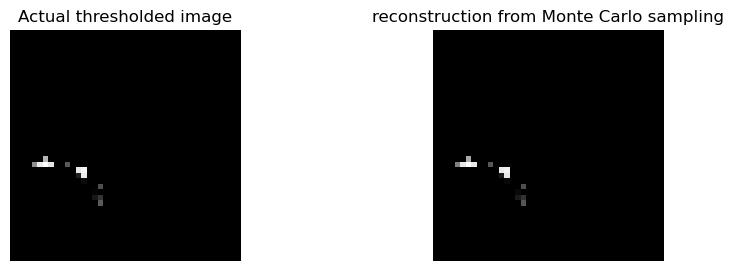

In [56]:
from src.sampling import get_frequency_array

freq_mat = get_frequency_array(prob_matrix.shape[1], prob_matrix.shape[2], rows, cols)
fig, ax = plt.subplots(1,2, figsize = (10,3))

plot_section(prob_matrix[0], ax = ax[0])
plot_section(freq_mat, ax = ax[1])
ax[0].set_title('Actual thresholded image')
ax[1].set_title('reconstruction from Monte Carlo sampling')
plt.show()

<hr>
<p>We apply all the steps shown above to all the VISp slices. This is the actual step needed for the analysis.</p>


In [51]:
from src.utils import apply_threshold_matrix
from src.sampling import sample_indices_from_probability_array

NUM_SAMPLES = 80000

prob_mat = np.zeros((num_images, max_dim, max_dim))

for islice, ccf_zslice in enumerate(collect_stpt_data):
    arr = apply_threshold_matrix(ccf_zslice['image'], 
                                low_thresh = GLOBAL_INTENSITY_THRESH[ccf_zslice['side']],
                                high_thresh = GLOBAL_INTENSITY_THRESH[ccf_zslice['side']] + 2000)
    C, R = arr.shape
    prob_mat[islice, :C, :R] = arr
        
prob_mat = prob_mat/prob_mat.sum()

sampled_zindex, sampled_rows, sampled_cols = sample_indices_from_probability_array(prob_mat, N_sample=NUM_SAMPLES).T

<hr>
<p> We convert the row, column and zindex sampled above into actual CCF coordinate to be used in computing the cell type fractions.
Most of the code below simply to undoes the cropping of VISp we had performed and place the VISp back in global brain coordinate system. Also, we place points sampled from both left and right VISp on the right part of the brain due to the CCF left-right symmetry (as we have done for the MERFISH in the first part of this notebook.)
</p>

In [59]:
xyz_sampled = {}
for side in ['left', 'right']: 
    xyz_sampled[side] = np.empty((0,3))

for islice, ccf_zslice in enumerate(collect_stpt_data):
    idx = np.where(sampled_zindex == islice)

    rw = sampled_rows[idx]
    cl = sampled_cols[idx]
    
    # The rows and columns were sampled from an array cropped to VISp.
    # Translate the coordinates to coordinates of the full ccf slice.
    noise_rows = np.random.uniform(0,1, len(rw)) #uniform shifts within voxels
    noise_cols = np.random.uniform(0,1, len(cl)) #uniform shifts within voxels

    x_ccf = (cl + ccf_zslice['range']['min_col']).astype(np.float32) 
    if ccf_zslice['side'] == 'right':
        x_ccf  = x_ccf + CHANNEL.Lx//2  #shift by midpoint for right-lobe

    if ccf_zslice['side'] == 'left':
        x_ccf = CHANNEL.Lx - x_ccf - 1 

    x_ccf =  x_ccf + noise_cols
        
    y_ccf = (rw + ccf_zslice['range']['min_row']).astype(np.float32) + noise_rows
    z_ccf = ccf_zslice['z'] * np.ones_like(x_ccf, dtype=np.float32)

    x_ccf = x_ccf * CHANNEL.dx  # coordinates in mm
    y_ccf = y_ccf * CHANNEL.dy  # coordinates in mm
    z_ccf = z_ccf * CHANNEL.dz  # coordinates in mm
    
    r_ccf = np.array([x_ccf, y_ccf, z_ccf]).T
    
    xyz_sampled[ccf_zslice['side']] = np.vstack((xyz_sampled[ccf_zslice['side']], r_ccf))

<p> The cell below repeats the above sampling procedure to uniformly sample coordinates from VISp region over slices in z_ideal. Such collection of VISp coordinates are stored in <code>xyz_uniform_sampled</code>. We will use this in the final part of analysis to get normalization constants needed to get probability densities $P(x|s)$ using the neural network implementations of $P(s|x)$ via Bayes' theorem.</p>

In [60]:
max_dim_uniform = 0
collect_uniform_data = []

for islice, zindex in enumerate(z_ideal): 
    
    im, im_range = crop_structure(vox = stpt_annotation, 
                                  zindex=zindex, 
                                  parcels_in_struc=parcels_in_struc, 
                                  annotation_voxobj=stpt_annotation)

    for side in ['left', 'right']:

        collect_uniform_data.append({'z': zindex, 
                          'image': im[side],
                          'side' : side,
                          'range': im_range[side]})

        max_dim_uniform = max(max_dim_uniform, im[side].shape[0])

prob_mat_uniform = np.zeros((num_images, max_dim_uniform, max_dim_uniform))

for islice, ccf_zslice in enumerate(collect_uniform_data):
    arr = apply_threshold_matrix(ccf_zslice['image'], 
                                low_thresh = 0.0,
                                high_thresh = 0.1)
    C, R = arr.shape
    prob_mat_uniform[islice, :C, :R] = arr
        
prob_mat_uniform = prob_mat_uniform/prob_mat_uniform.sum()

sampled_uniform_zindex, sampled_uniform_rows, sampled_uniform_cols = np.where(prob_mat_uniform)

xyz_uniform_sampled = {}
for side in ['left', 'right']: 
    xyz_uniform_sampled[side] = np.empty((0,3))

for islice, ccf_zslice in enumerate(collect_uniform_data):
    idx = np.where(sampled_uniform_zindex == islice)

    rw = sampled_uniform_rows[idx]
    cl = sampled_uniform_cols[idx]
    
    # The rows and columns were sampled from an array cropped to VISp.
    # Translate the coordinates to coordinates of the full ccf slice.
    noise_rows = np.random.uniform(0,1, len(rw)) #uniform shifts within voxels
    noise_cols = np.random.uniform(0,1, len(cl)) #uniform shifts within voxels

    x_ccf = (cl + ccf_zslice['range']['min_col']).astype(np.float32) 
    if ccf_zslice['side'] == 'right':
        x_ccf  = x_ccf + CHANNEL.Lx//2  #shift by midpoint for right-lobe

    if ccf_zslice['side'] == 'left':
        x_ccf = CHANNEL.Lx - x_ccf - 1 

    x_ccf =  x_ccf + noise_cols
        
    y_ccf = (rw + ccf_zslice['range']['min_row']).astype(np.float32) + noise_rows
    z_ccf = ccf_zslice['z'] * np.ones_like(x_ccf, dtype=np.float32)

    x_ccf = x_ccf * CHANNEL.dx  # coordinates in mm
    y_ccf = y_ccf * CHANNEL.dy  # coordinates in mm
    z_ccf = z_ccf * CHANNEL.dz  # coordinates in mm
    
    r_ccf = np.array([x_ccf, y_ccf, z_ccf]).T
    
    xyz_uniform_sampled[ccf_zslice['side']] = np.vstack((xyz_uniform_sampled[ccf_zslice['side']], r_ccf))

<h2> Part-IV: Determine the cell-type fractions</h2>

<p> At each of the sampled points $\mathbf{x}_\text{samp} = (x,y,z)$ from GFP distribution $Q_\text{GFP}(\mathbf{x}_\text{samp})$, we also have the probability $P\left(s|\mathbf{x}_\text{samp}\right)$ to find a cell of subclass $s$ that we modelled via neural network. Now, let us consider a simpler question before moving to a more refined one:  
    
<p><i>If we have prior knowledge that the gene tool is very specific, and it can tag only one cell type, then which cell type's spatial distribution best describes the GFP/RFP cells' spatial distribution?</i></p>  

<p>The similarity of two probability distributions is measured through the cross-entropy between the two distribution. To answer the above question, we need to find the subclass $s$ for which  
$$ {\cal H}(P,Q) = 
    -\sum_{\mathbf{x} } Q_\text{GFP}(\mathbf{x}) \log\left(P\left(\mathbf{x}|s\right)\right)$$
 is <i>minimized</i>.  The sum on the right hand side is over all $\mathbf{x}$ in VISp. The probabilities $P(\mathbf{x}|s)$ can be obtained from the MLP implemented $P(s|\mathbf{x})$ via Bayes' theorem, $P\left(\mathbf{x}|s\right) = \frac{P\left(s|\mathbf{x}\right)}{ \sum_{\mathbf{x}'} P\left(s|\mathbf{x}'\right)}$.
If $\mathbf{x}$'s are sampled by Monte Carlo from $Q_\text{GFP}(\mathbf{x})$, the sum on the right hand side simply becomes a simple sum, $\sum_{\mathbf{x}\sim Q_\text{GFP}(x) } \log\left(P\left(s|\mathbf{x}\right)\right)$. We have the data for the samples of GFP coordinates $\mathbf{x}\sim Q_\text{GFP}(x)$ as well as estimates of $\log\left(P\left(s|\mathbf{x}\right)\right)$, and hence we can find this cross-entropy between MERFISH's $P$ and GFP's $Q_\text{GFP}$.  </p>
    
<p> 
However, a gene tool can tag more than one cell-type. They seem to be typically around 3 to 4 as from Figure-4 of Ben-Simon et al (2025). Thus, we refine our question to </p>

<p><i>If we have prior knowledge that the gene tool has target specificity of $K$ cell-types, then which cell-type $K$-plet's  spatial distribution best describes the GFP/RFP cells' spatial distribution?</i></p> 

<p> There are $N$-choose-$K$ possible $K$-plets of cell-type that can be picked from $N$ cell-type/subclasses, and let's call this set ${\cal K}$ and its elements $k \in {\cal K}$.  For example, for a 3-plet (triplet!), the elements of the set ${\cal K}$ could be $k_1 =$(Astro-TE NN, L6b CTX Glut, ABC NN), $k_2 =$ (ABC NN, Endo NN, Lamp5 Gaba), etc.  Now, each of those $K$-plets of cell-types have a probability distribution $$ P(k_i|x) \propto \sum_{s \in K\text{-plet}} P(s|x).$$ The best estimate of $K$-plet that best describes the spatial distribution $Q_\text{GFP}$ is the one that again minimizes the cross-entropy
$${\cal H}' = -\sum_{\mathbf{x} } Q_\text{GFP}(\mathbf{x}) \log\left(P\left(\mathbf{x}| k_i\right)\right).$$
Again, the sum on the right hand side can be estimated through a sum over Monte Carlo sampled positions $\mathbf{x}_\text{samp}$, and $P\left(k_i|\mathbf{x}\right)$ can be determined from sum of neural network estimated $P(s|x)$ over subclasses $s$ comtained in the $K$-plet $k_i$.</p>

<p>Once the best $K$-plet $k_i$ is determined through the above procedure, the average fractions $f_s$ of cell-types $s \in k_i$ over the VISp are  $$ f_s  = \sum_{\mathbf{x}} Q_\text{GFP}(\mathbf{x}) \frac{P(s|\mathbf{x})}{\sum_{s'\in k_i} P(s'|\mathbf{x}) }.$$  The above equation is the spatial average of the fraction of type $s$ at various locations $\mathbf{x}$  and the average is taken with respect to GFP probability $Q$. The above sum becomes a simple sum over Monte Carlo sampled GFP locations. </p>

<p> The cells below implement the above procedure. The user needs to specify what they think is the best $K$. The choice of $K$ is a trade-off between bias versus noise in the determination of $f_s$. We will use $K=1,2,3$ and 4 for this challenge, and find fractions $f_s$ for each of the choices.</p>

<hr>

Choose the value of <code> K_target</code> which specifies the expected cell-type specificity $K$ for your gene tool. Without knowledge, enter your best possible prior.                                                              

In [61]:
K_target = 3

<hr>
<h3> Determine $\log(P(s|\mathbf{x}))$ at all Monte Carlo sampled $\mathbf{x}_\text{sampled}$ from GFP/RFP distribution</h3>
<p> The cell below collates the Monte Carlo sampled GFP/RFP coordinates, and finds $\log(P(s|\mathbf{x}))$ at those locations using <code>prob_model</code>. We store the result in left and right sides separately to make data plotting easier, and to allow the user be able to extract side specific information if needed. </p>

In [62]:
collate_log_prob = {}
collate_log_prob['left'] = {}
collate_log_prob['right'] = {}


collate_uniform_log_prob = {}
collate_uniform_log_prob['left'] = {}
collate_uniform_log_prob['right'] = {}

"""
First collect all log class probabilities from 
all sections for use later in specific analysis.
"""
for side in ['left', 'right']: 

    scaled_xyz = scale_pos(xyz_sampled[side]).copy()
    scaled_xyz = torch.from_numpy(scaled_xyz)
    log_prob = prob_model(scaled_xyz)
    collate_log_prob[side] = log_prob

# The terms below are need to normalize distributions P(x|s) obtained from P(s|x) via Bayes' theorem.
    scaled_uniform_xyz = scale_pos(xyz_uniform_sampled[side]).copy()
    scaled_uniform_xyz = torch.from_numpy(scaled_uniform_xyz)
    log_prob_uniform = prob_model(scaled_uniform_xyz)
    collate_uniform_log_prob[side] = log_prob_uniform

<p> The cell below determines $P(s|x)$ by applying <code>softmax</code> to  <code>log_prob</code>, which is the output of <code>prob_model</code>

In [63]:
# Collect all log probability from z, side-label dict 
# into one numpy array
#NCLASS = 28
log_prob_all = torch.empty((0, NSUBCLASS)).float()
log_prob_uniform_all = torch.empty((0, NSUBCLASS)).float()
for side in ['left', 'right']:
    log_prob = collate_log_prob[side]
    log_prob_all = torch.vstack( (log_prob_all, log_prob) )

    log_prob_uniform = collate_uniform_log_prob[side]
    log_prob_uniform_all = torch.vstack( (log_prob_uniform_all, log_prob_uniform) )

# Probability of subclasses at each location
# shape prob_all:  N_site X N_class
eps = 1.0E-12

prob_all = torch.softmax(log_prob_all, axis = -1).detach().numpy() + eps
prob_uniform_all = torch.softmax(log_prob_uniform_all, axis = -1).detach().numpy() + eps

<h3>  Determine cross-entropy for spatial distributions of $K$-plet of subclasses and GFP/RFP voxels</h3>

<p> For $N=28$ subclasses in VISp, finding probability distributions for 28-choose-K combinations of subclasses can be numerically daunting. To alleviate this, we reduce the net size of $N$ to a choice of <code>NCLASS_CUTOFF = 15</code> subclasses which have the top one-class cross-entropies over VISp. That is to say, these <code>NCLASS_CUTOFF = 15</code> individually by themselves look closer to GFP's spatial distribution. This is just a pragmatic choice that we found to work in obvious training cases.  </p>

In [64]:
import itertools 

NCLASS_CUTOFF = 15

normalized_prob_all = np.log(prob_all/np.expand_dims(prob_uniform_all.sum(axis=0), axis=0))
crossentropy_1class = normalized_prob_all.mean(axis=0) #.detach().numpy()
arg_include_1class = np.argsort(crossentropy_1class)[::-1]

combinations_iterator = itertools.combinations(arg_include_1class[:NCLASS_CUTOFF], K_target)
comb= np.array(list(combinations_iterator), dtype=np.int32)

<p>The cell below finds the cross-entropies of all $K$-plets of subclasses and finds the fraction $f_s$ in all such $K$-plets. The final results are sorted by cross-entropies. We will pick the top choice as our prediction.</p>

In [66]:
# shape prob_combination_K:  N_site X N_combination X K_target
### Below is the efficient implementation of 
### prob_combination_K = np.array([p[comb] for p in prob_all])
prob_combination_K = prob_all[ np.arange(len(prob_all))[:, None, None] , comb ]
prob_uniform_combination_K = prob_uniform_all[ np.arange(len(prob_uniform_all))[:, None, None] , comb ]
# change shape of prob_combination_K:
# N_site X N_combination X K_target  --> N_combination X N_site X K_target
prob_combination_K = np.moveaxis(prob_combination_K, [0,1,2], [1,0,2])

# The terms below are need to normalize distributions P(x|s) obtained from P(s|x) via Bayes' theorem.
# N_site X N_combination X K_target  --> N_combination X N_site X K_target
prob_uniform_combination_K = np.moveaxis(prob_uniform_combination_K, [0,1,2], [1,0,2])
#N_combination X N_site X K_target -> N_combination X N_site -> N_combination -> N_combination X 1
normalization_combination_K = prob_uniform_combination_K.sum(axis=-1).sum(axis=-1) #N_combination
normalization_combination_K  = np.expand_dims(normalization_combination_K, axis=-1)

# log-likelihood of a combination at any site is sum of probabilities 
# occuring within that combination.
# shape log_prob_combination_K: N_combination X N_site
log_prob_combination_K = np.log( prob_combination_K.sum(axis=-1)/normalization_combination_K )

# Kullbeck-Liebler divergence of a combination taken over all sampled STPT sites.
# shape cross_entropy_combination_K: N_combination
#####cross_entropy_combination_K = log_prob_combination_K.mean(axis=-1)
cross_entropy_combination_K = log_prob_combination_K.mean(axis=-1)

# Sort combination in ascending order of KL div.
arg_K = np.argsort(cross_entropy_combination_K)[::-1]
sorted_cross_entropy_combination_K = cross_entropy_combination_K[arg_K]

#Get the indices of the top subclass combination and project probabilities 
# within that combination to 1. That is, we ask for all probabilities 
# given the hypothesis that the top combination describes all STPT data.
top_combination_K_idx = comb[ arg_K[0] ]  #shape: K_target
top_prob_combination_K = prob_combination_K[arg_K[0]] #shape: N_site X K_target
top_prob_combination_K = \
    top_prob_combination_K/np.expand_dims(top_prob_combination_K.sum(axis=-1), axis=-1)

#Compute the fraction of subclasses from top-combination occuring over all STPT sites,
# by marginalizing top_prob_combination_K over STPT locations.
frac_class = top_prob_combination_K.mean(axis=0) #shape: K_target
arg_frac =  np.argsort(frac_class)[::-1]

#Uncomment this, if you want to plot cross-entropy of sorted K-plets
#plxax = np.arange(1,len(sorted_cross_entropy_combination_K)+1)
#plt.plot(plxax,sorted_cross_entropy_combination_K)
#plt.xlim((0,0.1))
#plt.xscale('log')

<hr>
<hr>
<h2> Result for fractions $f_s$ of cell-types </h2>

In [67]:
frac_sort = frac_class[arg_frac]
subclass_sort = [id_to_subclass[idx]  for idx in top_combination_K_idx[arg_frac] ]
result = dict(zip(subclass_sort, frac_sort))
result = pd.DataFrame.from_dict(result, orient='index')
result.columns = ['fractions (mean)']
result

fractions (mean)
005 L5 IT CTX Glut          0.702306
032 L5 NP CTX Glut          0.295954
056 Sst Chodl Gaba          0.001743

<h2> Plot spatial distributions of top cell types and compare it to GFP/RFP cells in various CCF slices</h2>
<p> In the plots below, the rows are for various specific CCF z-slices. The red colored blobs are the spatial densities of GFP/RFP cells in that z-slice. The $K$ columns from left to right show results for our estimate of the best $K$ subclasses present. The columns are ordered such that the subclass with highest fraction $f_s$ is shown on the leftmost column and the least fraction in the rightmost column. The color density plot in each plot is the spatial distribution $P(s|x)$ of the class specified on top of that plot on that z-slice. The color bar on the side of each plot shows the values of $P(s|x)$. </p>

<p>  MERFISH cells of all celltypes in the VISp of that CCF slice is shown in white. But, be keep in mind that we have pooled MERFISH cells from multiple CCF slices of about 0.1 micron thickness to make that plot. </p>

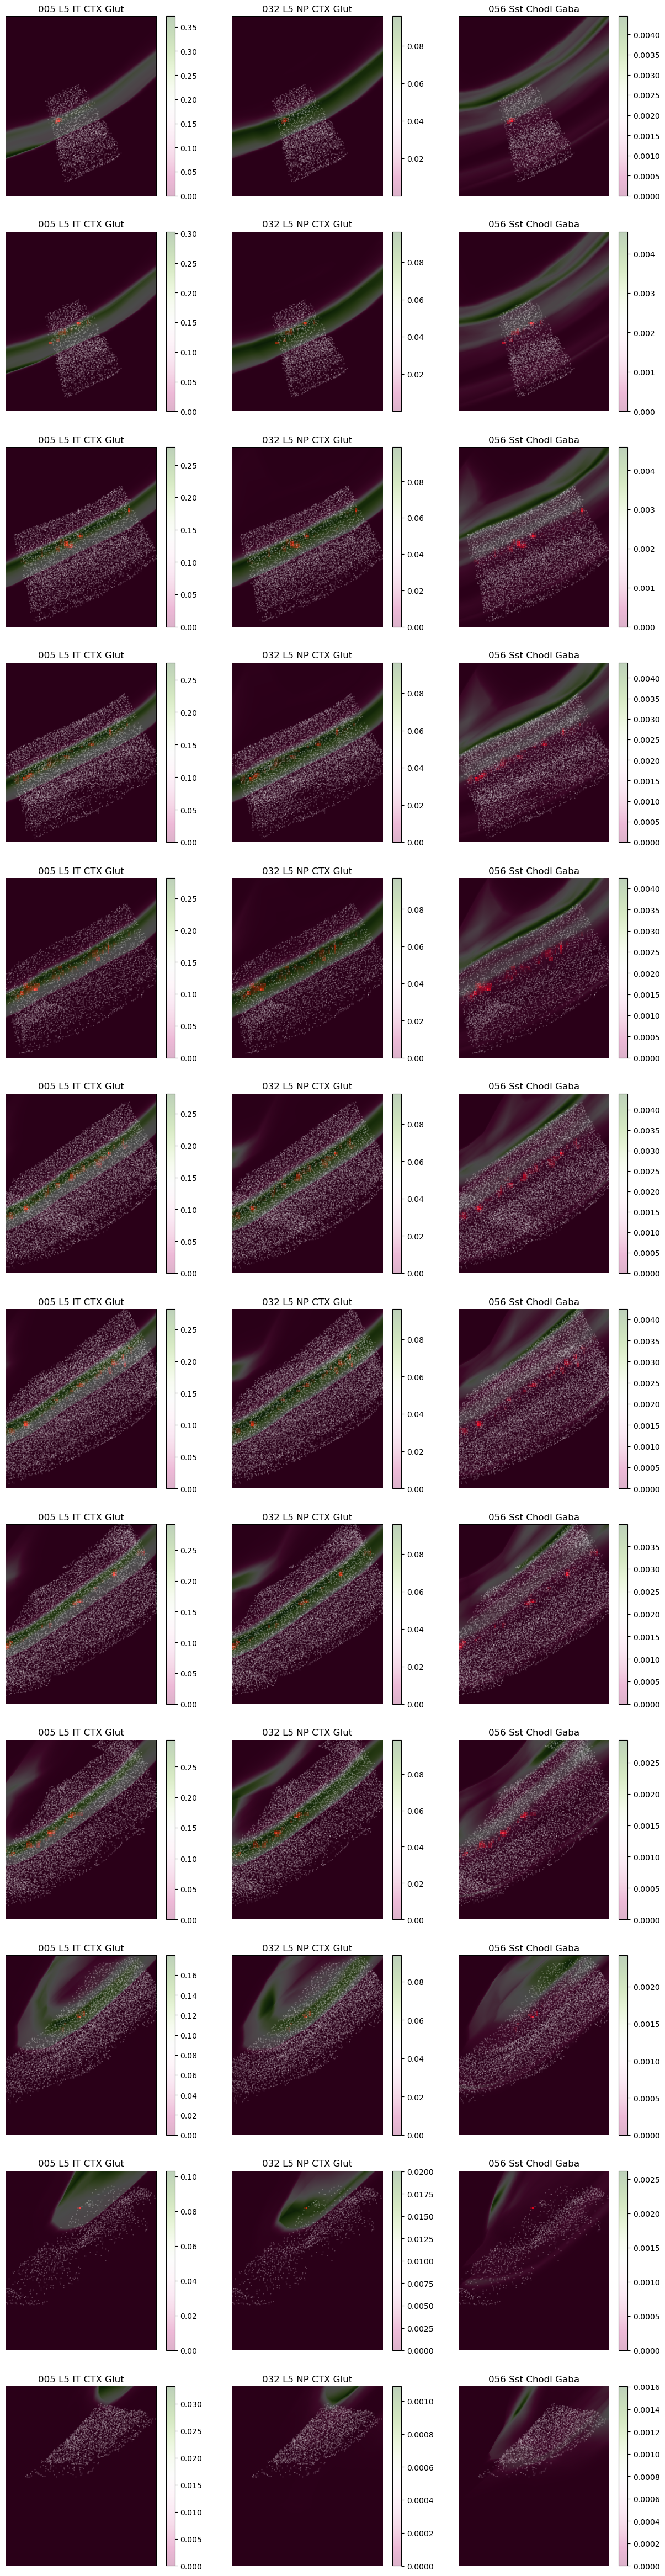

In [74]:
import matplotlib.colors as mcolors

def transparent_cmap(color, N=256):
    """Creates a colormap that goes from transparent to the given color."""
    return mcolors.LinearSegmentedColormap.from_list(
        'transparent_to_color', [(0, 0, 0, 0), color], N=N
    )
color = (1, 0, 0, 1)
cmap = transparent_cmap(color)

step_size = 3

nsize = len(z_ideal[::step_size])
fig, ax = plt.subplots(1 * nsize, K_target, figsize=(5*K_target, 5 * 1 * nsize), squeeze=False)

j=0
for side in ['left']: # side_list:
    for i_z, z in enumerate(z_ideal[::step_size]):

        z_ccf = z * stpt_annotation.dz

        #### Get Merfish cells within the slice ###
        select = (abs(df_cell_xy['x_ccf'] - z_ccf) <= 0.1)
        df_merfish = df_cell_xy[select]
        ###################################################################
        # Plot 2d density plot of GFP/RFP density in red
        ###################################################################

        select = (np.abs(xyz_sampled[side].T[2] - z_ccf) < 0.00001)
        stpt_slice = xyz_sampled[side][select].copy()

        stpt_slice = scale_pos(stpt_slice)
        for k in range(K_target):
            ax[j][k].hist2d(stpt_slice.T[0], stpt_slice.T[1], bins=80, 
                            alpha=1.0, cmap = cmap, 
                            range=[[-1.5, 1.5],[-1.5, 1.5]])

        ###################################################################
        # Plot class probability densities determined using neural network
        ###################################################################
        x_grid = np.arange(-1.5, 1.5, 0.005)
        y_grid = np.arange(-1.5, 1.5, 0.005)
        x_mesh, y_mesh = np.meshgrid(x_grid, y_grid) 

        z_mesh = np.ones_like(x_mesh) * (z_ccf - z_centroid)/sigma_z 

        
        Xinp = np.array([x_mesh, y_mesh, z_mesh], dtype=np.float32).T
        Xinp = torch.from_numpy(Xinp)
        pdist = torch.softmax(prob_model(Xinp), axis=-1) + 1.0E-13
        pdist = pdist.detach().numpy().T
        pdist_K = pdist[top_combination_K_idx]/pdist[top_combination_K_idx].sum()
        for k in range(K_target):
            ax[j][k].set_title(id_to_subclass[top_combination_K_idx[arg_frac[k]]])
            im = ax[j][k].pcolormesh(x_mesh, y_mesh, 
                                     pdist[top_combination_K_idx[arg_frac[k]]], 
                                     alpha=0.3, cmap=plt.colormaps['PiYG'])
            fig.colorbar(im, ax=ax[j][k])
        #####################################

        sdist = df_merfish[['z_ccf_folded', 'y_ccf', 'x_ccf']].to_numpy()
        sdist = scale_pos(sdist)
        for k in range(K_target):
            ax[j][k].scatter(*sdist.T[:2], color='white', s=0.35, alpha=0.2)
            ax[j][k].axis("off")

        #####################################
        j +=1

plt.show()

<hr>
<p> It is recommended that unwanted data be deleted before running another set of analysis.</p>

In [84]:
try:
    del xyz_sampled, df_merfish, x_grid, y_grid,  z_mesh, x_mesh, y_mesh, sdist, pdist, Xinp, stpt_slice, fig, ax, prob_combination_K, log_prob_combination_K,\
KL_divergence_combination_K, arg_K, sorted_KL_divergence_combination_K, top_prob_combination_K, frac_class, arg_frac, scaled_xyz, log_prob, comb,\
collate_log_prob, log_prob_all, sampled_zindex, sampled_rows, sampled_cols, collect_stpt_data, red_channel, green_channel, CHANNEL
except:
    print('variables already deleted')

try:
    del cell_everything
except:
    print('cell_everything already deleted')

gc.collect()

18